# Test CPOP on data from the Tunisian stock exchange

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

from src import (
    CPOP,
    LogCost,
    continuous_piecewise_linear_approximation,
    reconstruct_segmentation,
)
from scipy.stats import median_abs_deviation

In [2]:
def plot_approximation(
    y,
    changepoints,
    beta,
    sigma,
    h=LogCost(1),
    stock_name="Unspecified",
    X=None,
):
    # Add the first and last index to changepoints
    changepoints = np.concatenate(([0], changepoints, [len(y) - 1]))

    phis = reconstruct_segmentation(y, changepoints, sigma, beta, h)
    approx = continuous_piecewise_linear_approximation(changepoints, phis)

    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor("lightgrey")
    ax.patch.set_facecolor("white")
    ax.plot(y, alpha=0.7, label="Original signal")
    ax.plot(approx, color="red", label="Approximation", alpha=0.7)
    ax.scatter(changepoints, phis, color="red", label="Changepoints")
    ax.set_title(
        "Stock : "
        + stock_name
        + "\n"
        + r"$\beta$ = "
        + str(beta)
        + r", $\gamma$ = "
        + str(h.scale),
        fontsize=20,
    )
    # set xtick labels
    if X is not None:
        xticks = np.linspace(0, len(y) - 1, 10, dtype=int)
        xtick_labels = [X[i] for i in xticks]
        ax.set_xticks(xticks, xtick_labels, fontsize=12)
    ax.set_xlabel("Time", fontsize=15)
    ax.set_ylabel("Price", fontsize=15)
    ax.legend(fontsize=10)

    diff = np.diff(changepoints)
    diff[0] += 1
    cost = (
        np.sum((y - approx) ** 2) / sigma**2
        + (len(changepoints) - 2) * beta
        + np.sum([h(seg_len) for seg_len in diff])
    )

    text = (
        "Number of changepoints: "
        + str(len(changepoints))
        + "\n"
        + "Cost: "
        + str(round(cost, 2))
    )

    fig.text(0.08, -0.05, text, horizontalalignment="left", wrap=True, fontsize=12)
    ax.grid()
    plt.show()

    return approx, fig

## Data pre-processing

In [3]:
data_df = pd.read_csv("./data/TN stock market/ALL_DATA.csv")
data_df.head()

,Ticker,Date,Open,High,Low,Close,Volume
0,AB,2022-10-24,24.58,24.58,24.58,24.58,130
1,AB,2022-10-26,23.90,24.58,23.90,23.90,14301
2,AB,2022-10-27,24.58,24.58,24.57,24.58,505
3,AB,2022-10-28,24.58,24.58,24.09,24.58,5882
4,AB,2022-10-31,24.58,24.58,24.57,24.58,1240


We will focus on the "High" column

In [4]:
data_df = data_df[["Ticker", "Date", "Close"]]

In [5]:
stocks = data_df["Ticker"].unique()
print("The number of stocks is: ", len(stocks))

The number of stocks is:  88


### Missing points

There are few missing points, we remove them from the dataframe

In [6]:
data_df_null = data_df[data_df.isnull().any(axis=1)]
# count by Ticker
null_by_stock = {}
for stock in stocks:
    if len(data_df_null[data_df_null["Ticker"] == stock]) != 0:
        null_by_stock[stock] = len(data_df_null[data_df_null["Ticker"] == stock])

print(len(null_by_stock), "stocks have missing values.")
for stock in null_by_stock:
    print(
        stock,
        " has ",
        null_by_stock[stock],
        " missing values (",
        round(null_by_stock[stock] / len(data_df[data_df["Ticker"] == stock]) * 100, 2),
        "%)",
    )

3 stocks have missing values.
AST  has  10  missing values ( 1.51 %)
PLTU  has  10  missing values ( 3.19 %)
SIMPA  has  2  missing values ( 0.1 %)


In [7]:
data_df = data_df.dropna()

### Duplicate values

In [8]:
(data_df.duplicated().sum() / len(data_df)) * 100
# see where the duplicates are
df_duplicates = pd.DataFrame(
    data_df[data_df.duplicated(keep=False)]
    .sort_values(by=["Ticker", "Date"])
    .groupby(["Ticker"])
    .count()
)
data_df[data_df.duplicated(keep=False)].sort_values(by=["Ticker", "Date"]).groupby(
    ["Ticker"]
).count()
# supress column Dates of df_duplicates
df_duplicates = df_duplicates.drop(columns=["Date"])
# rename column Close to Number of duplicates
df_duplicates = df_duplicates.rename(columns={"Close": "Number of duplicates"})
# add column with the total number of rows for each stock
df_duplicates["Total number of rows"] = data_df.groupby(["Ticker"]).count()["Date"]
# add column with the percentage of duplicates
df_duplicates["Percentage of duplicates"] = (
    df_duplicates["Number of duplicates"] / df_duplicates["Total number of rows"] * 100
)
# sort by Percentage of duplicates
df_duplicates = df_duplicates.sort_values(
    by=["Percentage of duplicates"], ascending=False
)
# round percentage of duplicates to 2 decimals
df_duplicates["Percentage of duplicates"] = df_duplicates[
    "Percentage of duplicates"
].round(decimals=2)

/tmp/ipykernel_21717/569407154.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_duplicates.index, rotation=90, fontsize=12)


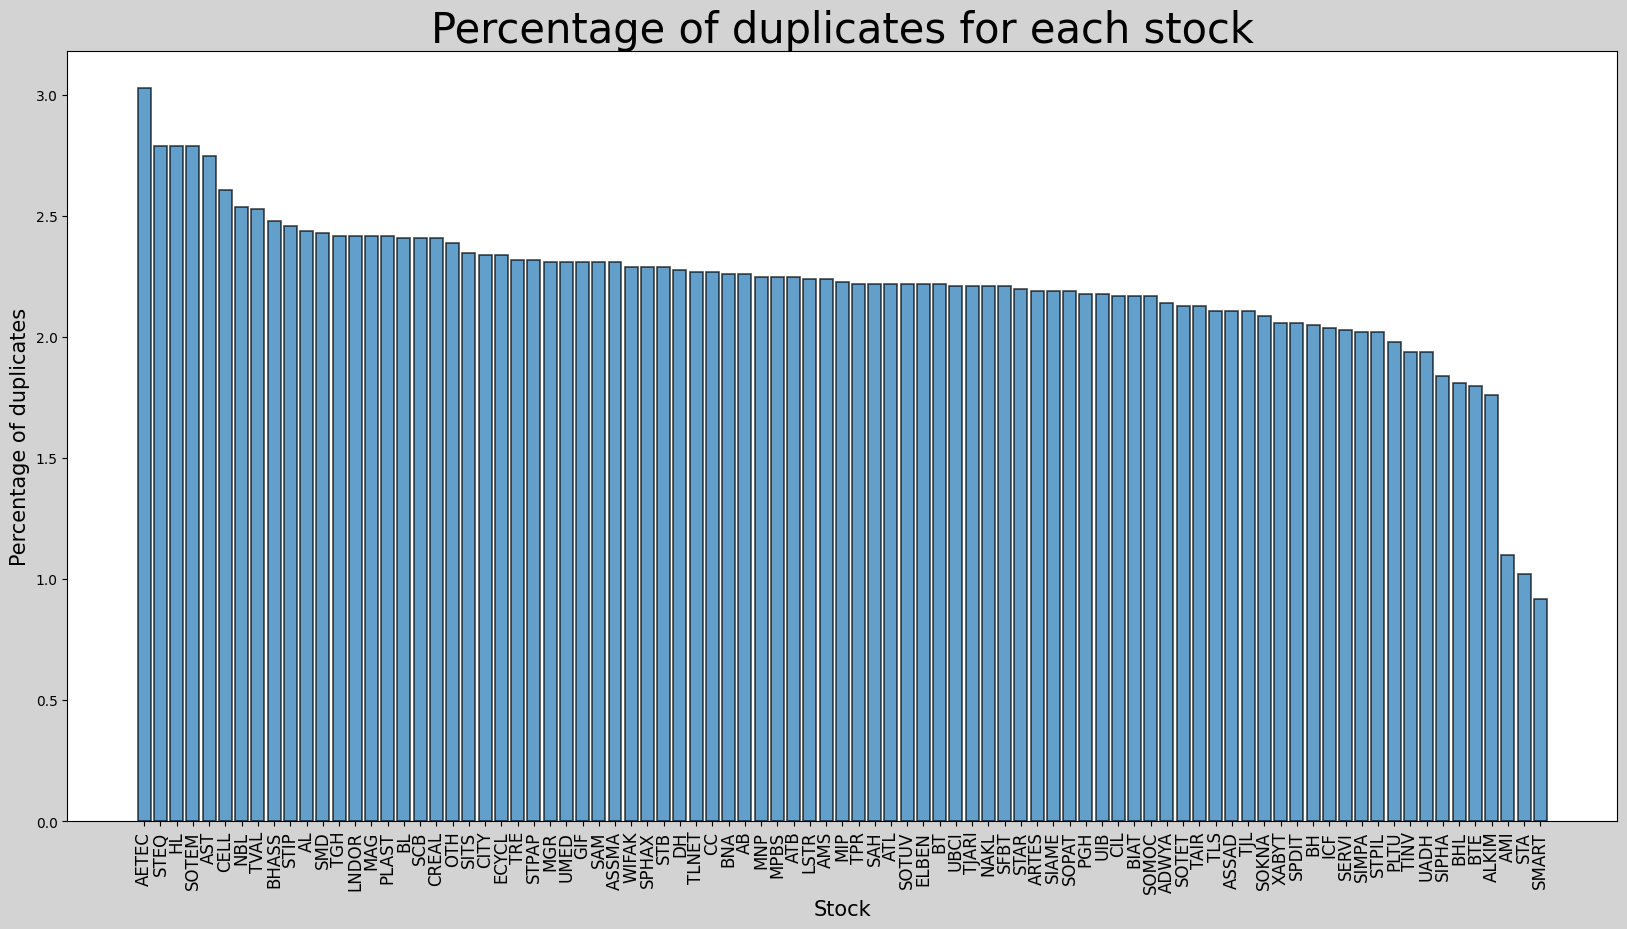

In [9]:
# plot the percentage of duplicates
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor("lightgrey")
ax.patch.set_facecolor("white")
ax.bar(
    df_duplicates.index,
    df_duplicates["Percentage of duplicates"],
    edgecolor="black",
    linewidth=1.2,
    alpha=0.7,
)
ax.set_xticklabels(df_duplicates.index, rotation=90, fontsize=12)
ax.set_xlabel("Stock", fontsize=15)
ax.set_ylabel("Percentage of duplicates", fontsize=15)
ax.set_title("Percentage of duplicates for each stock", fontsize=30)
plt.show()

We remove duplicates values

In [10]:
# remove duplicates
data_df = data_df.drop_duplicates()

### Date to int conversion

In [11]:
# We convert the dataframe to a dictionary of tuples. The keys are the stock names and the values are a tuple of the dates and the closing prices.

stock_dict = {}
for stock in stocks:
    stock_dict[stock] = (
        data_df[data_df["Ticker"] == stock]["Date"],
        data_df[data_df["Ticker"] == stock]["Close"],
    )

In [12]:
for stock in stocks:
    X, y = stock_dict[stock][0].values, stock_dict[stock][1].values
    X_int = []
    for date in X:
        year, month, date = date.split("-")
        date = datetime.date(int(year), int(month), int(date))
        X_int.append(date.toordinal())
    # indices sort
    X_int = np.array(X_int)
    indices = np.argsort(X_int)
    X_int = X_int[indices]
    y = y[indices]
    X_int = X_int - X_int[0]
    stock_dict[stock] = (X_int, y)

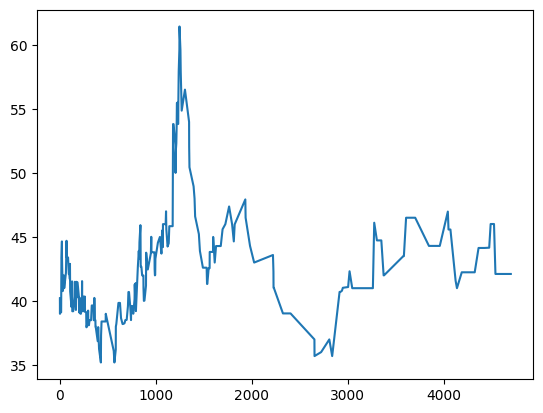

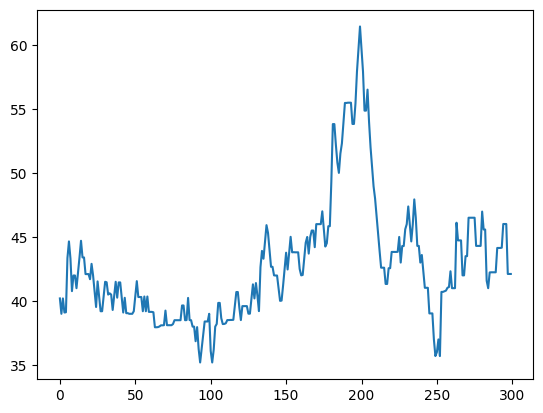

In [13]:
X_exple, y_exple = stock_dict["PLTU"]
plt.plot(X_exple, y_exple)
plt.show()
plt.plot(y_exple)
plt.show()

The points are not spaces evenly in time. We interpolate the data linearly to fix this.

### Linear interpolation

In [14]:
def interpolate_linearly(X, y):
    X_int, y_int = [], []
    for i in range(len(X) - 1):
        slope = (y[i + 1] - y[i]) / (X[i + 1] - X[i])
        for j in range(X[i], X[i + 1]):
            X_int.append(j)
            y_int.append(y[i] + slope * (j - X[i]))
    return np.array(X_int), np.array(y_int)

In [15]:
stock_dict_int = {}
for stock in stocks:
    X, y = stock_dict[stock][0], stock_dict[stock][1]
    X_int, y_int = interpolate_linearly(X, y)
    stock_dict_int[stock] = (X_int, y_int)

### Histogram of sizes by stock

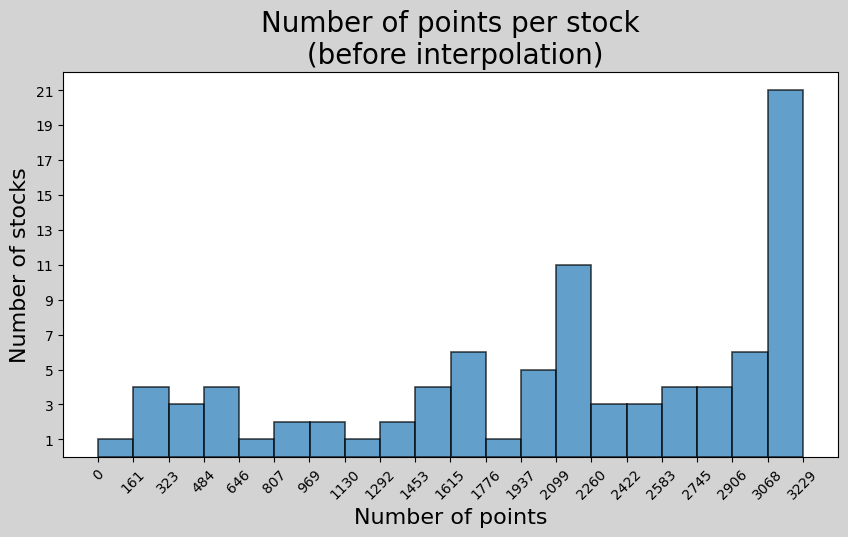

In [16]:
size_by_stock = {}
for stock in stocks:
    size_by_stock[stock] = len(stock_dict[stock][0])

sizes = list(size_by_stock.values())

fig, ax = plt.subplots(figsize=(10, 5))
fig.set_facecolor("lightgrey")
ax.set_facecolor("white")
ax.set_title("Number of points per stock\n (before interpolation)", fontsize=20)
# align ticks with bins
step = np.max(sizes) / 20
ticks = [0]
for i in range(20):
    ticks.append(ticks[-1] + step)
ax.set_xticks(ticks)
ax.set_yticks([i for i in range(1, 25, 2)])
# set tick orientation
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_xlabel("Number of points", fontsize=16)
ax.set_ylabel("Number of stocks", fontsize=16)
ax.hist(sizes, bins=20, edgecolor="black", linewidth=1.2, alpha=0.7)
plt.show()

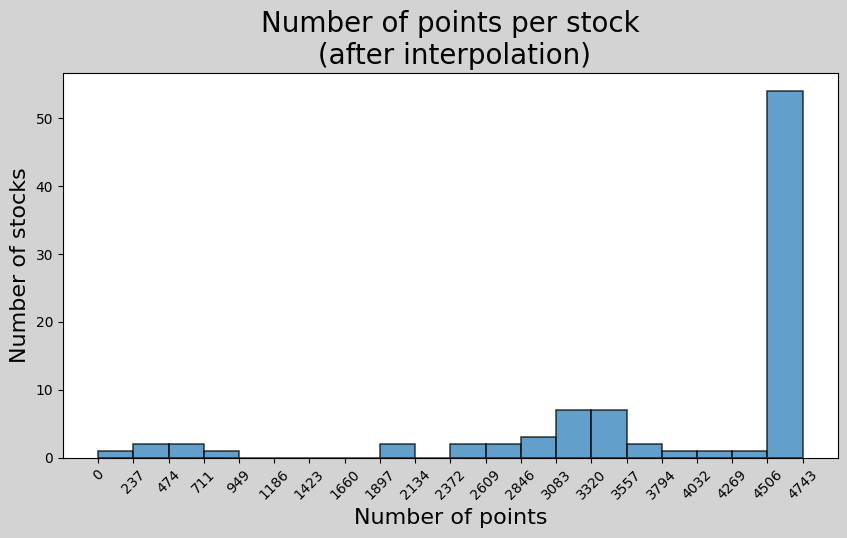

In [17]:
size_by_stock_int = {}
for stock in stocks:
    size_by_stock_int[stock] = len(stock_dict_int[stock][0])

sizes = list(size_by_stock_int.values())

fig, ax = plt.subplots(figsize=(10, 5))
fig.set_facecolor("lightgrey")
ax.set_facecolor("white")
ax.set_title("Number of points per stock\n (after interpolation)", fontsize=20)
# align ticks with bins
step = np.max(sizes) / 20
ticks = [0]
for i in range(20):
    ticks.append(ticks[-1] + step)
ax.set_xticks(ticks)
# ax.set_yticks([i for i in range(1, 25, 2)])
# set tick orientation
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_xlabel("Number of points", fontsize=16)
ax.set_ylabel("Number of stocks", fontsize=16)
ax.hist(sizes, bins=20, edgecolor="black", linewidth=1.2, alpha=0.7)
plt.show()

### Sub-sampling to get at most n_sub_sample points

In [18]:
stock_dict_subsample = {}
n_sub_sample = 500
for stock in stocks:
    X, y = stock_dict_int[stock][0], stock_dict_int[stock][1]
    if len(X) > n_sub_sample:
        # subsample the time series to n_sub_sample points at fixed intervals
        subsample_indices = np.linspace(0, len(X) - 1, n_sub_sample, dtype=int)
        X = X[subsample_indices]
        y = y[subsample_indices]
    stock_dict_subsample[stock] = (X, y)

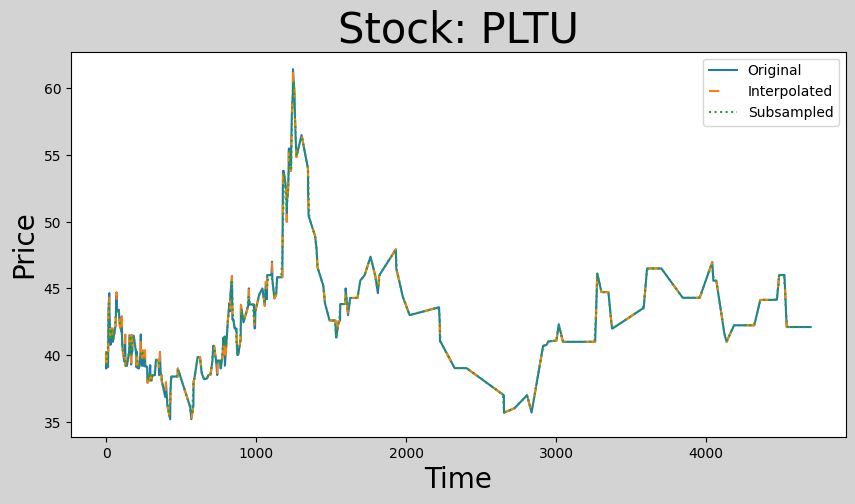

In [19]:
stock = "PLTU"
X_emp, y_emp = stock_dict[stock][0], stock_dict[stock][1]
X_int, y_int = stock_dict_int[stock][0], stock_dict_int[stock][1]
X_sub, y_sub = stock_dict_subsample[stock][0], stock_dict_subsample[stock][1]

fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor("lightgrey")
ax.patch.set_facecolor("white")
ax.set_title("Stock: " + stock, fontsize=30)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Price", fontsize=20)

ax.plot(X_emp, y_emp, label="Original")
# wide dashes
ax.plot(X_int, y_int, label="Interpolated", linestyle="--", dashes=(5, 10))
ax.plot(X_sub, y_sub, label="Subsampled", linestyle=":")
ax.legend(fontsize=10)
plt.show()

### Remove stocks with less than n_min_points

Stock:  AMI  has  180  points


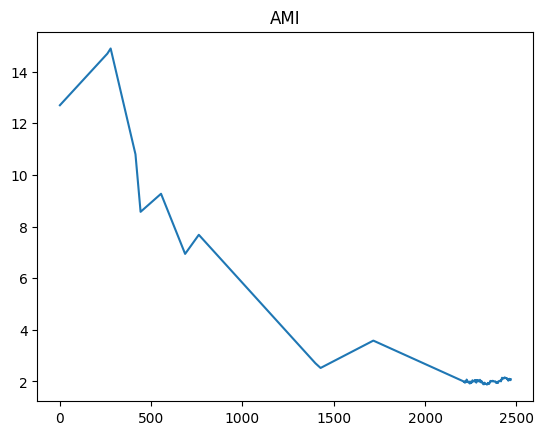

Stock:  AMV  has  1  points


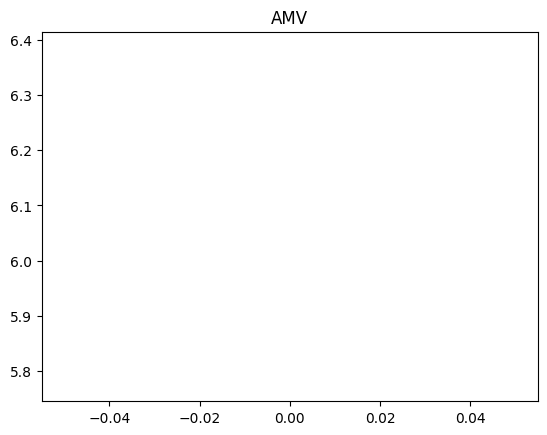

Stock:  STA  has  196  points


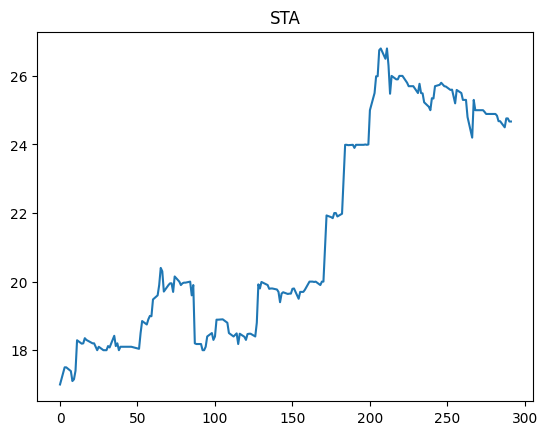

In [20]:
n_min_points = 200

for stock in stocks:
    if size_by_stock[stock] < n_min_points:
        print("Stock: ", stock, " has ", size_by_stock[stock], " points")
        plt.plot(stock_dict[stock][0], stock_dict[stock][1])
        plt.title(stock)
        plt.show()

In [21]:
for stock in stocks:
    if size_by_stock[stock] < n_min_points:
        stock_dict.pop(stock)

stocks = list(stock_dict.keys())

## Test of the algorithm

### Simple test

Stock:  AB  ( 1 / 2 )
Iterations 450/500 : 727 taus stored


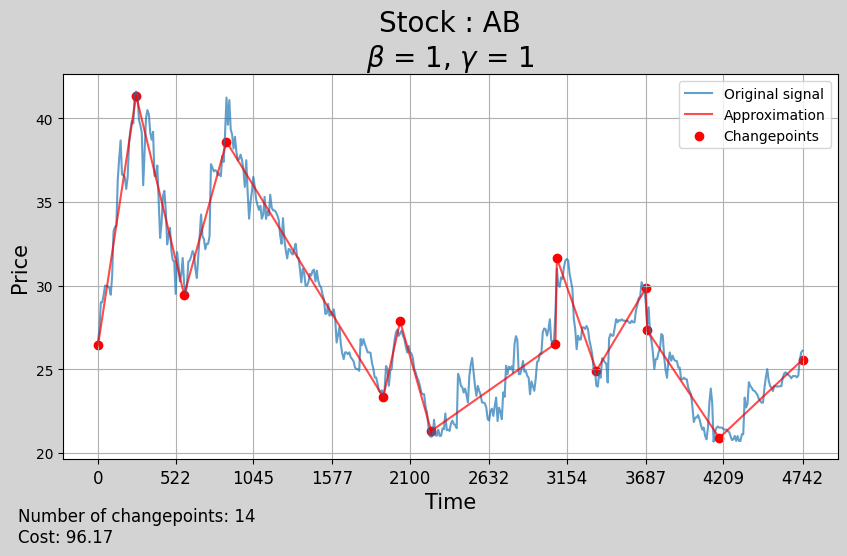

Stock:  ADWYA  ( 2 / 2 )
Iterations 450/500 : 738 taus storedd


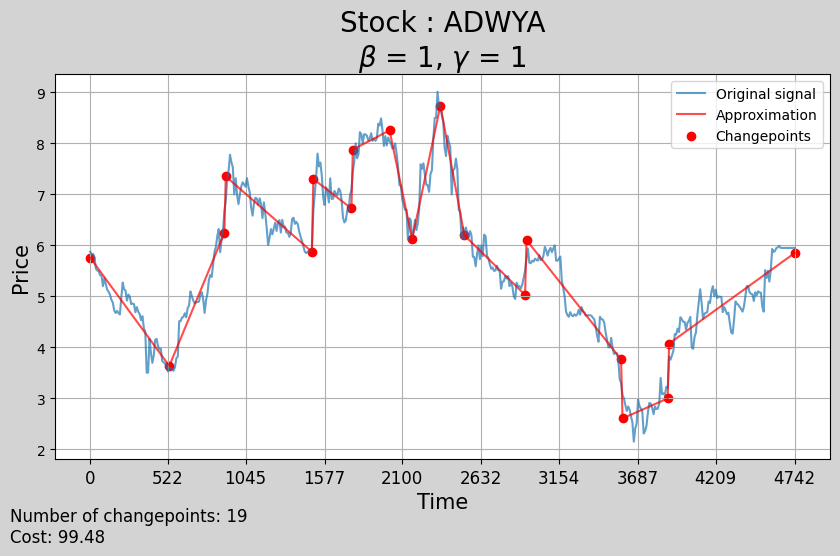

In [22]:
save = True

# Fix hyperparameters
beta = 1
scale = 1

for i, stock_name in enumerate(stocks[:2]):
    print("Stock: ", stock_name, " (", i + 1, "/", len(stocks[:2]), ")")
    X, y = stock_dict_subsample[stock_name][0], stock_dict_subsample[stock_name][1]

    sigma = median_abs_deviation(y)
    changepoints_cpop = CPOP(y, beta, sigma=sigma, verbose=True)

    approx, fig = plot_approximation(
        y, changepoints_cpop, beta, sigma, stock_name=stock_name, X=X
    )
    if save:
        folder = "./figures/all_stocks_beta_{}_scale_{}".format(beta, scale) + "/"
        file = "{}".format(stock_name) + ".png"
        if os.path.exists(folder) == False:
            os.makedirs(folder)
        path = folder + file
        fig.savefig(path, bbox_inches="tight")

### Beta influence analysis

Iterations 450/500 : 29 taus stored


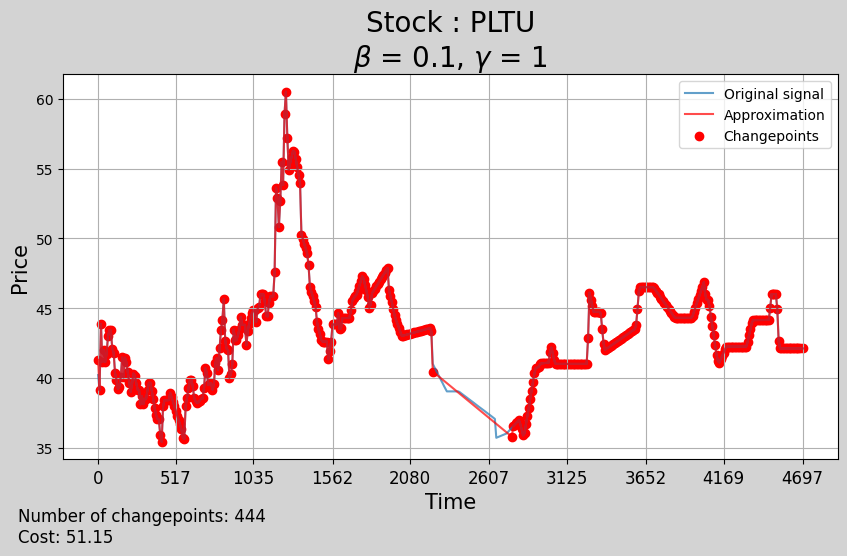

Iterations 450/500 : 462 taus stored


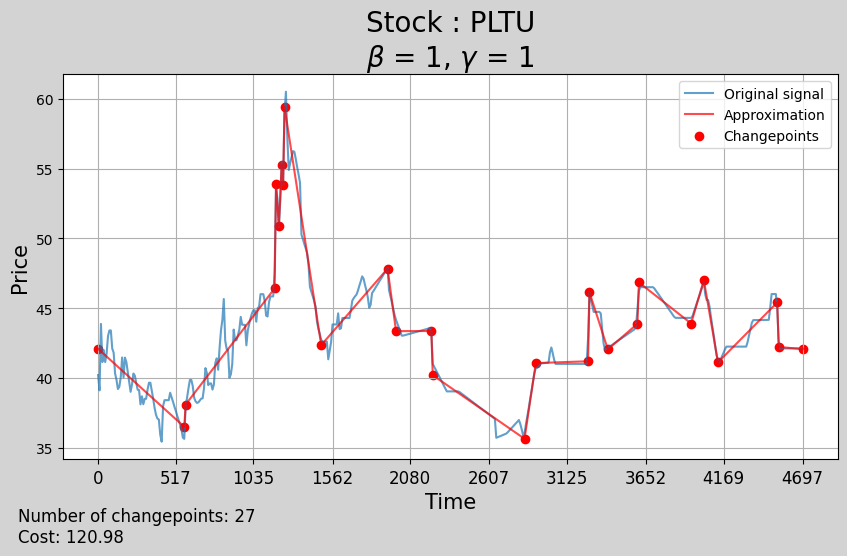

Iterations 450/500 : 1002 taus stored


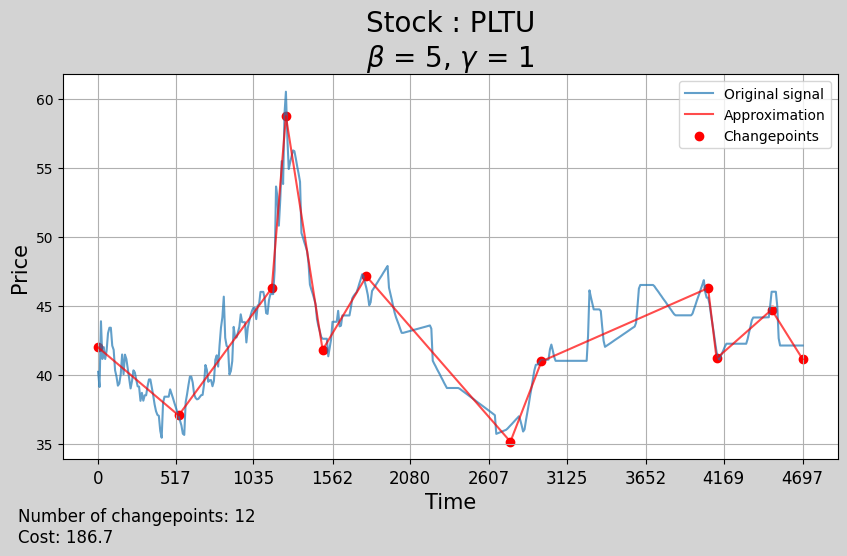

Iterations 450/500 : 2413 taus stored


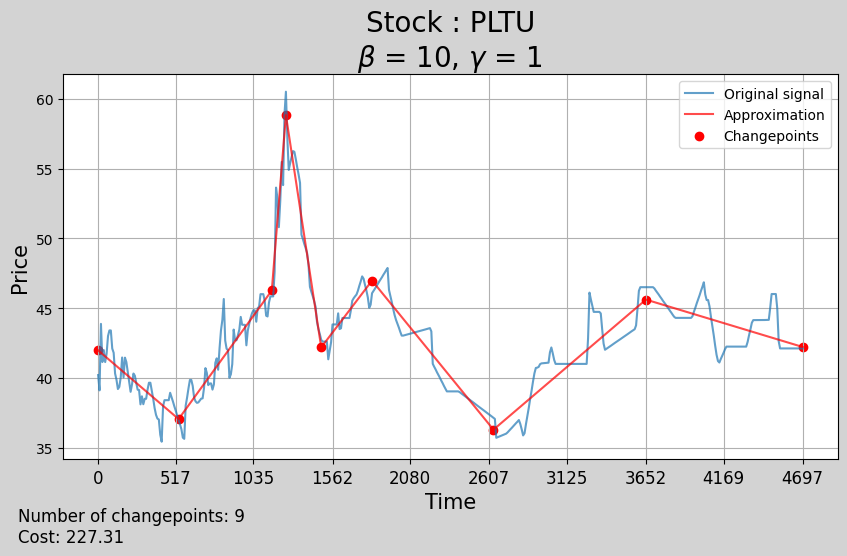

Iterations 450/500 : 4225 taus stored


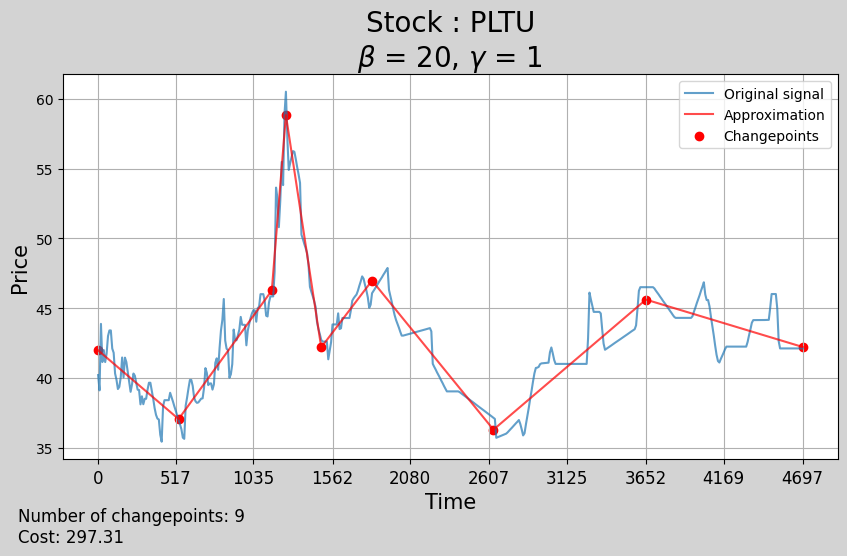

In [23]:
save = True

stock = "PLTU"
beta_list = [0.1, 1, 5, 10, 20]
sigma = median_abs_deviation(stock_dict_subsample[stock][1])
scale = 1

X, y = stock_dict_subsample[stock][0], stock_dict_subsample[stock][1]
for beta in beta_list:
    changepoints_cpop = CPOP(y, beta, sigma=sigma, verbose=True)
    approx, fig = plot_approximation(
        y, changepoints_cpop, beta, sigma, stock_name=stock, X=X
    )
    if save:
        folder = "./figures/beta_analysis_scale_{}_stock_{}".format(scale, stock) + "/"
        file = "beta_{}".format(beta) + ".png"
        if os.path.exists(folder) == False:
            os.makedirs(folder)
        path = folder + file
        fig.savefig(path, bbox_inches="tight")

### $h$ influence analysis

Iterations 450/500 : 226 taus stored


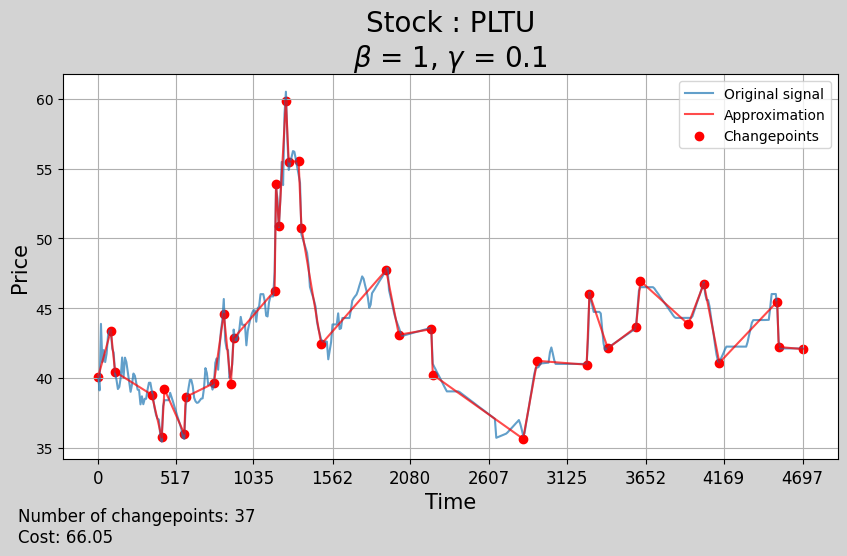

Iterations 450/500 : 462 taus stored


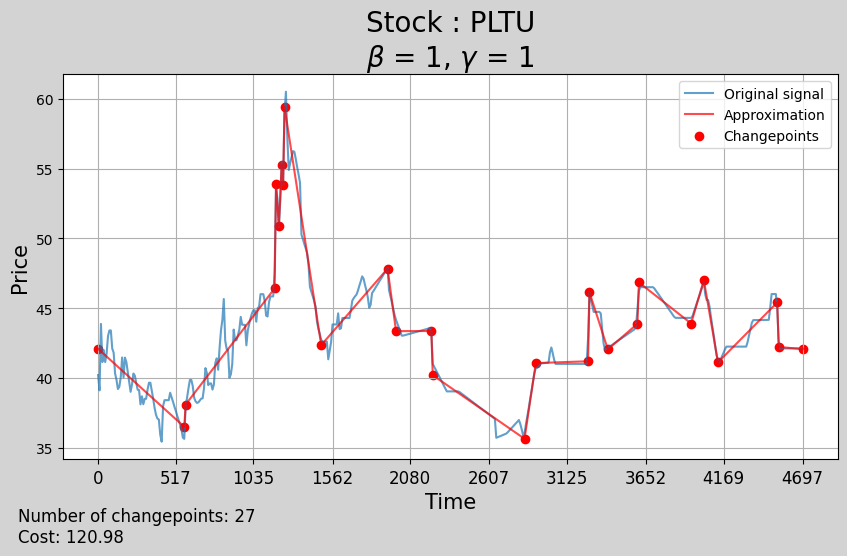

Iterations 450/500 : 566 taus stored


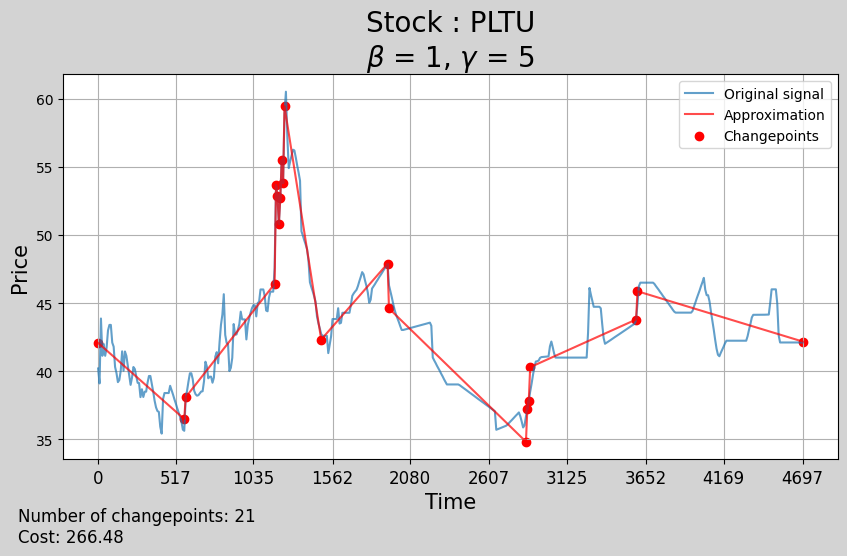

Iterations 450/500 : 502 taus stored


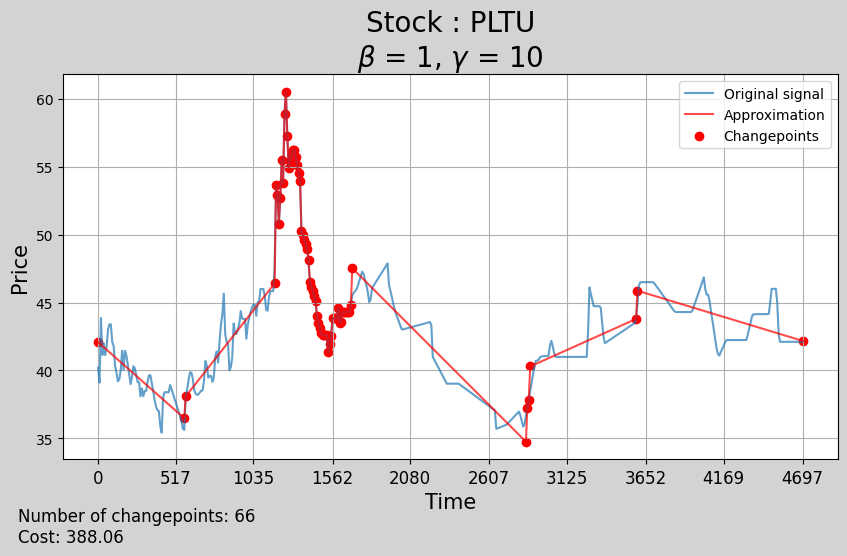

Iterations 450/500 : 227 taus stored


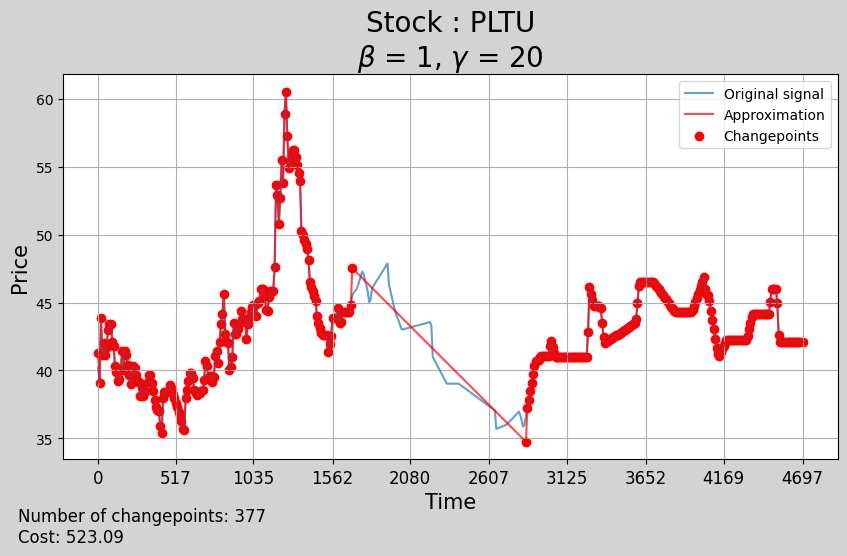

In [24]:
save = True

stock = "PLTU"
scale_list = [0.1, 1, 5, 10, 20]
sigma = median_abs_deviation(stock_dict_subsample[stock][1])
beta = 1

X, y = stock_dict_subsample[stock][0], stock_dict_subsample[stock][1]
for scale in scale_list:
    changepoints_cpop = CPOP(y, beta, LogCost(scale), sigma, verbose=True)
    approx, fig = plot_approximation(
        y, changepoints_cpop, beta, sigma, LogCost(scale), stock_name=stock, X=X
    )
    if save:
        folder = "./figures/scale_analysis_beta_{}_stock_{}".format(beta, stock) + "/"
        file = "scale_{}".format(scale) + ".png"
        if os.path.exists(folder) == False:
            os.makedirs(folder)
        path = folder + file
        fig.savefig(path, bbox_inches="tight")